In [1]:
# Install necessary libraries
!pip install transformers torch
!pip install torch
!pip install pandas matplotlib tqdm

# Import required libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns




  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
# Load the dataset
df = pd.read_csv('final_data.csv')

# Load Indic BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

# Tokenize input texts
tokenized_texts = tokenizer(list(df['Tweet']), padding=True, truncation=True, return_tensors="pt")

# Convert string labels to numerical labels
label_map = {label: index for index, label in enumerate(df['party'].unique())}
df['label'] = df['party'].map(label_map)

# Prepare labels
labels = torch.tensor(df['label'])

# Create TensorDataset
dataset = TensorDataset(tokenized_texts['input_ids'], tokenized_texts['attention_mask'], labels)

# Define batch size
batch_size = 8

# Create DataLoader
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

# Splitting the dataset into train and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize and prepare validation dataset
validation_tokenized_texts = tokenizer(list(validation_df['Tweet']), padding=True, truncation=True, return_tensors="pt")
validation_labels = torch.tensor(validation_df['label'].tolist())  # Convert Series to list
validation_dataset = TensorDataset(validation_tokenized_texts['input_ids'], validation_tokenized_texts['attention_mask'], validation_labels)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

# Load pre-trained Indic BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=len(df['party'].unique()))

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 1/4, Loss: 0.9806, Accuracy: 0.5699
Epoch 2/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 2/4, Loss: 0.5485, Accuracy: 0.7695
Epoch 3/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 3/4, Loss: 0.2574, Accuracy: 0.9030
Epoch 4/4


Iteration:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch 4/4, Loss: 0.1784, Accuracy: 0.9224


Validation:   0%|          | 0/77 [00:00<?, ?it/s]

Validation Accuracy: 0.9376

BERT Classifier Metrics:
Recall: 0.9376
F1 Score: 0.9362
Accuracy: 0.9376


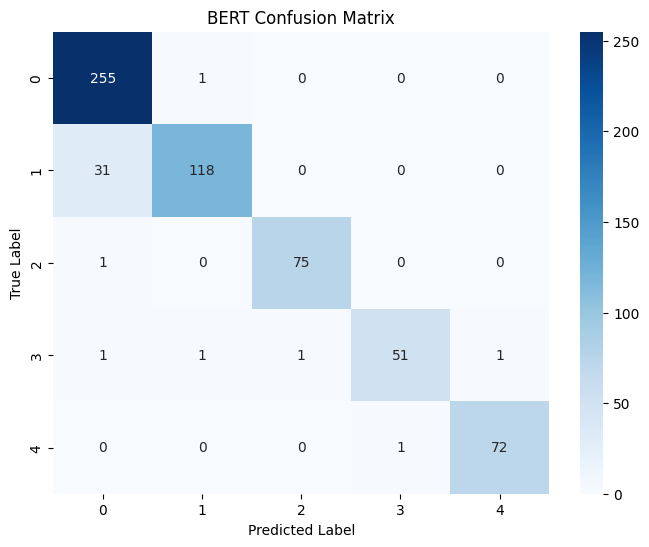

In [4]:
# Training parameters
epochs = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Get the device
model.to(device)  # Move the model to the device

# Lists to store training loss and accuracy
train_loss_values = []
train_accuracy_values = []

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training step
    for batch in tqdm(dataloader, desc="Iteration"):
        batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        # Compute training loss
        epoch_loss += loss.item()

        # Compute training accuracy
        _, predicted_labels = torch.max(logits, 1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[2].size(0)

    # Calculate average epoch loss and accuracy
    avg_epoch_loss = epoch_loss / len(dataloader)
    train_loss_values.append(avg_epoch_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracy_values.append(train_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}')

# Validation
model.eval()
correct_val_predictions = 0
total_val_predictions = 0
predicted_labels_list = []

for batch in tqdm(validation_dataloader, desc="Validation"):
    batch = tuple(t.to(device) for t in batch)  # Move input tensors to the device
    with torch.no_grad():
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        correct_val_predictions += (predicted_labels == batch[2]).sum().item()
        total_val_predictions += batch[2].size(0)
        predicted_labels_list.extend(predicted_labels.cpu().numpy().tolist())

# Calculate validation accuracy
val_accuracy = correct_val_predictions / total_val_predictions

print(f'Validation Accuracy: {val_accuracy:.4f}')

# Calculate metrics for BERT
bert_recall = recall_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
bert_f1 = f1_score(validation_df['label'], predicted_labels_list, average='weighted', zero_division=1)
bert_accuracy = accuracy_score(validation_df['label'], predicted_labels_list)

print("\nBERT Classifier Metrics:")
print(f"Recall: {bert_recall:.4f}")
print(f"F1 Score: {bert_f1:.4f}")
print(f"Accuracy: {bert_accuracy:.4f}")

# Create confusion matrix
confusion_matrix_bert = confusion_matrix(validation_df['label'], predicted_labels_list)

# Plot heat map for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_bert, annot=True, fmt="d", cmap="Blues")
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()